## Домашнее задание №4

1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.

2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков .

3. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.

4. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек.

5. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10*i-й до (i+1)*10 -й,... ,от 90 до 100-й точках (используйте осреденение по десяткам точек)

6. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.

#### 1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os

from random import random
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

%matplotlib inline

In [2]:
Path_Energy = 'my_PJME_MW.csv'
data_energy = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

data_energy.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [3]:
data_energy_W = data_energy.resample('W').mean()
data_energy_W.drop(columns=['hour','dayofyear', 'dayofmonth', 'dayofweek'], inplace=True)
data_energy_W.head()

,PJME_MW,year,month,quarter,weekofyear,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,
2002-01-06,32392.160839,2002.0,1.000000,1.0,1.0,0.160839,0.000000,0.167832
2002-01-13,31487.386905,2002.0,1.000000,1.0,2.0,0.000000,0.000000,0.000000
2002-01-20,31452.880952,2002.0,1.000000,1.0,3.0,0.000000,0.142857,0.000000
2002-01-27,30141.529762,2002.0,1.000000,1.0,4.0,0.142857,0.000000,0.142857
2002-02-03,29196.488095,2002.0,1.428571,1.0,5.0,0.000000,0.000000,0.000000


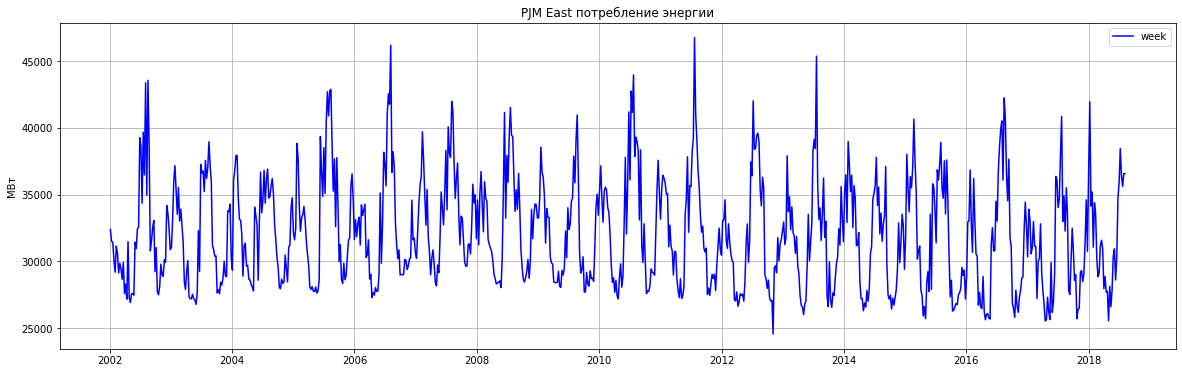

In [4]:
plt.figure(figsize =(20,6))
plt.plot(data_energy_W.index, data_energy_W['PJME_MW'], 'b', label ='week')

plt.ylabel('МВт')
plt.title('PJM East потребление энергии')
plt.legend()
plt.grid()
plt.show();

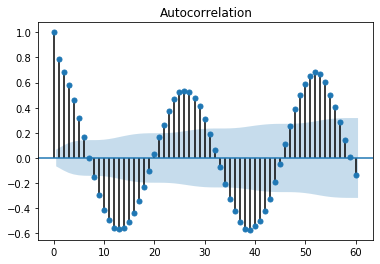

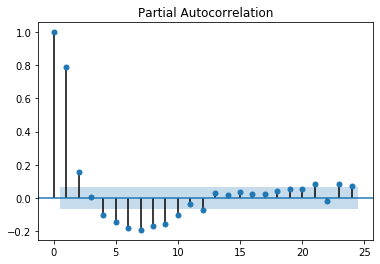

In [5]:
sm.graphics.tsa.plot_acf(data_energy_W['PJME_MW'].values, lags=60)
sm.graphics.tsa.plot_pacf(data_energy_W['PJME_MW'].values, lags=24)

plt.show()

In [6]:
def split_data(data, split_date):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

In [7]:
data_energy_W['exp_0_05'] = exponential_smoothing(data_energy_W['PJME_MW'], 0.05)

In [8]:
# AR
p = 13
for i in range(p):
    data_energy_W['t'+str(p-i)]=0
    data_energy_W['t'+str(p-i)].values[p:] = data_energy_W['PJME_MW'].values[i:-(p)+i]

In [9]:
# I
first_diff = data_energy_W.iloc[1:,0].values - data_energy_W.iloc[:-1,0].values 
data_energy_W['diff1'] = 0
data_energy_W['diff1'].values[1:] = first_diff

In [10]:
# MA
data_energy_W['MA4']=data_energy_W['PJME_MW'].rolling(window=4).mean()
data_energy_W['MA13']=data_energy_W['PJME_MW'].rolling(window=13).mean()
data_energy_W['MA26']=data_energy_W['PJME_MW'].rolling(window=26).mean()
data_energy_W = data_energy_W.iloc[26:,:]

#### 2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков .

In [11]:
train, test = split_data(data_energy_W, '01-06-2016')

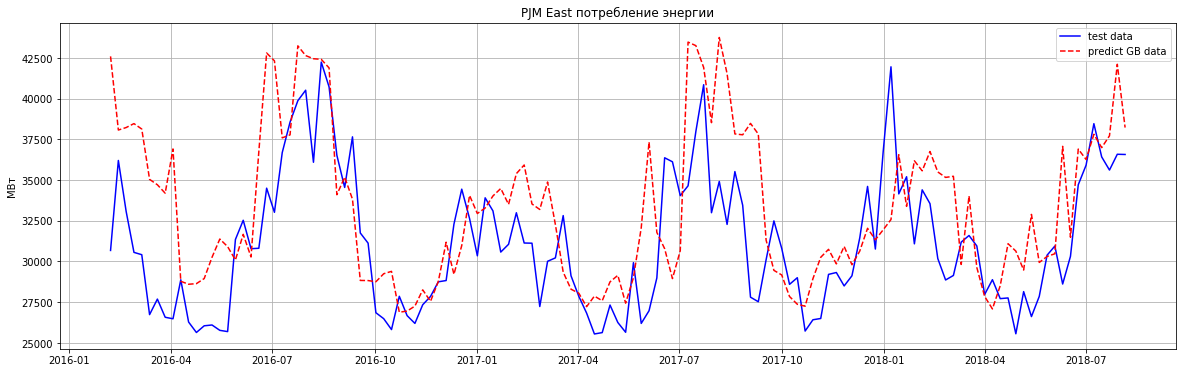

ошибка градиентного бустинга :   10.956455017310923 %


In [12]:
h = 4

X_train = train.iloc[:-h,:]
y_train = train['PJME_MW'].values[h:]
X_test = test.iloc[:-h,:]
y_test = test['PJME_MW'].values[h:]

model_gb = GradientBoostingRegressor(max_depth=10, random_state=0, n_estimators=50)
model_gb.fit( X_train, y_train) 
y_test_pred_gb = model_gb.predict(X_test)

plt.figure(figsize=(20, 6))

plt.ylabel('МВт')
plt.title('PJM East потребление энергии')
plt.plot(test.index[h:],y_test, 'b', label='test data')
plt.plot(test.index[h:],y_test_pred_gb,'--r', label='predict GB data')

plt.legend()
plt.grid()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test, y_pred=y_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g, '%')

#### 3. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.

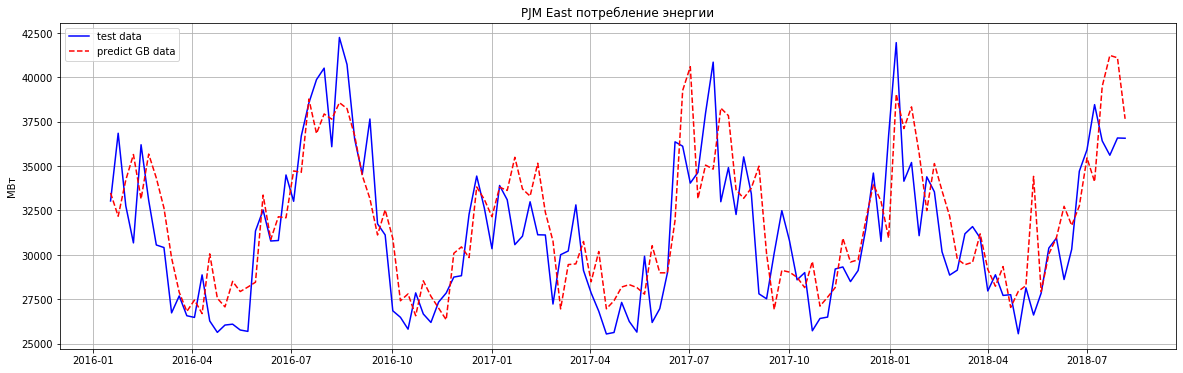

ошибка градиентного бустинга :   6.931967745033261 %


In [13]:
h = 1

X_train = train.iloc[:-h,:]
y_train = train['PJME_MW'].values[h:]
X_test = test.iloc[:-h,:]
y_test = test['PJME_MW'].values[h:]

model_gb_1 = GradientBoostingRegressor(max_depth=10, random_state=0, n_estimators=50)
model_gb_1.fit( X_train, y_train) 
y_test_pred_gb = model_gb_1.predict(X_test)

plt.figure(figsize=(20, 6))

plt.ylabel('МВт')
plt.title('PJM East потребление энергии')

plt.plot(test.index[h:],y_test, 'b', label='test data')
plt.plot(test.index[h:],y_test_pred_gb,'--r', label='predict GB data')

plt.legend()
plt.grid()
plt.show()

er_g = mean_absolute_percentage_error(y_true=y_test, y_pred=y_test_pred_gb)

print('ошибка градиентного бустинга :  ', er_g, '%')

In [14]:
# Избавляемся от значений PJME_MW и всех признаках построенных них

test_slide = test.copy()

test_slide['PJME_MW'] = None
test_slide['exp_0_05'] = None
test_slide['diff1'] = None
test_slide['MA4'] = None
test_slide['MA13'] = None
test_slide['MA26'] = None

p=13

for i in range(p):
    test_slide['t'+str(i+1)] = None
    
retro_data = train.shape[0]
test_slide = pd.concat([train, test_slide], axis=0)
test_slide

,PJME_MW,year,month,quarter,weekofyear,is_holiday,is_prev_holiday,is_next_holiday,exp_0_05,t13,t12,t11,t10,t9,t8,t7,t6,t5,t4,t3,t2,t1,diff1,MA4,MA13,MA26
Date,,,,,,,,,,,,,,,,,,,,,,,,,,
2002-07-07,38626.654762,2002.0,7.000000,3.0,27.0,0.142857,0.142857,0.142857,31247.511544,28308,27182,31484,27316,26929,27587,27606,27480,31448,30961,32444,32547,39257,-630,35718.982143,30836.467033,30303.015746
2002-07-14,34359.119048,2002.0,7.000000,3.0,28.0,0.000000,0.000000,0.000000,31403.091919,27182,31484,27316,26929,27587,27606,27480,31448,30961,32444,32547,39257,38626,-4267,36197.688988,31388.516026,30413.466982
2002-07-21,39671.779762,2002.0,7.000000,3.0,29.0,0.000000,0.000000,0.000000,31816.526311,31484,27316,26929,27587,27606,27480,31448,30961,32444,32547,39257,38626,34359,5312,37978.767857,32018.307692,30729.578475
2002-07-28,36481.577381,2002.0,7.000000,3.0,30.0,0.000000,0.000000,0.000000,32049.778865,27316,26929,27587,27606,27480,31448,30961,32444,32547,39257,38626,34359,39671,-3190,37284.782738,32723.283883,30973.426460
2002-08-04,43367.934524,2002.0,7.571429,3.0,31.0,0.000000,0.000000,0.000000,32615.686648,26929,27587,27606,27480,31448,30961,32444,32547,39257,38626,34359,39671,36481,6886,38470.102679,33987.780220,31518.482092
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-08,NaN,2018.0,7.000000,3.0,27.0,0.142857,0.142857,0.142857,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN
2018-07-15,NaN,2018.0,7.000000,3.0,28.0,0.000000,0.000000,0.000000,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN
2018-07-22,NaN,2018.0,7.000000,3.0,29.0,0.000000,0.000000,0.000000,NaN,None,None,None,None,None,None,None,None,None,None,None,None,None,None,NaN,NaN,NaN


In [15]:
p = 13

for i in range(test_slide.shape[0]-retro_data):
    ind_test = test_slide.iloc[[retro_data+i]].index
    ind_train = test_slide.iloc[[retro_data+i-1]].index
    test_slide.loc[ind_test,'PJME_MW'] = model_gb_1.predict(test_slide.loc[ind_train])
    
    # AR
    for j in range(p):
        ind_p = test_slide.iloc[[retro_data+i-(j+1)]].index
        test_slide.loc[ind_test, 't'+str(j+1)] = test_slide.loc[ind_p,'PJME_MW'].values

    # I
    test_slide.loc[ind_test,'diff1'] = (test_slide.loc[ind_test,'PJME_MW'].values - test_slide.loc[ind_train, 't'+str(j+1)].values)

    # MA
    test_slide.loc[ind_test,'MA4'] = data_energy_W['PJME_MW'].rolling(window=4).mean().loc[ind_test]
    test_slide.loc[ind_test,'MA13'] = data_energy_W['PJME_MW'].rolling(window=13).mean().loc[ind_test]
    test_slide.loc[ind_test,'MA26'] = data_energy_W['PJME_MW'].rolling(window=26).mean().loc[ind_test]
    test_slide.loc[:ind_test[0], 'exp_0_05'] = exponential_smoothing(test_slide.loc[:ind_test[0], 'PJME_MW'], 0.05)

#### 5. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до 10-й, от 10-й до 20-й, от 20-й до 30-й, .. .10i-й до (i+1)10 -й,... ,от 90 до 100-й точках (используйте осреденение по десяткам точек).

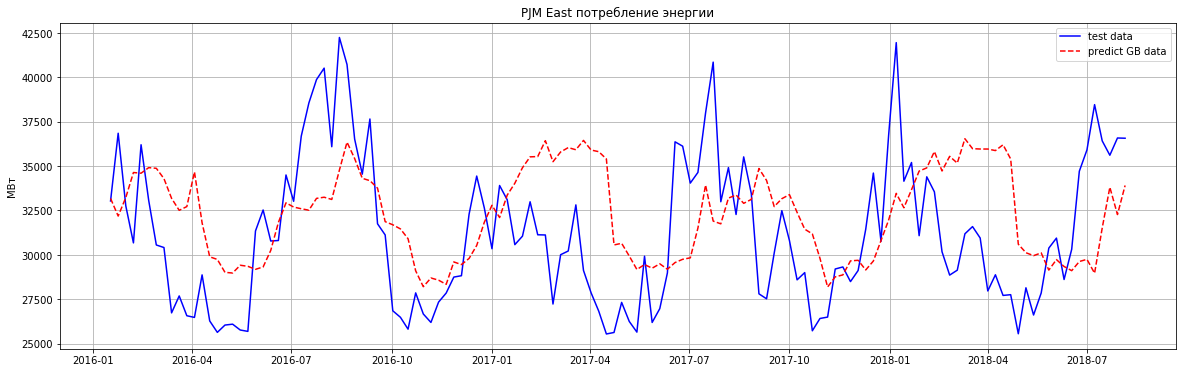

Общая ошибка градиентного бустинга :   6.931967745033261 %

Ошибка на измерениях (1 - 10): 10.585049088396666
Ошибка на измерениях (11 - 20): 15.169849734940572
Ошибка на измерениях (21 - 30): 9.014670325557827
Ошибка на измерениях (31 - 40): 10.656891183184433
Ошибка на измерениях (41 - 50): 5.268761386409119
Ошибка на измерениях (51 - 60): 12.546985361601154
Ошибка на измерениях (61 - 70): 21.394830467522056
Ошибка на измерениях (71 - 80): 11.359450060462235
Ошибка на измерениях (81 - 90): 8.917646222874488
Ошибка на измерениях (91 - 100): 7.85424260283725


In [16]:
plt.figure(figsize=(20, 6))
plt.plot(test.index[h:],y_test, 'b', label='test data')
plt.plot(test.index[h:],test_slide.loc[test.index[h:],'PJME_MW'],'--r', label='predict GB data')

plt.ylabel('МВт')
plt.title('PJM East потребление энергии')
plt.legend()
plt.grid()
plt.show()

print('Общая ошибка градиентного бустинга :  ', er_g, '%\n')
er_g = mean_absolute_percentage_error(y_true=y_test, y_pred=test_slide.loc[test.index[h:],'PJME_MW'])

for i in range(1,101,10): 
    print('Ошибка на измерениях ('+str(i)+' - '+str(i+9) +'):', mean_absolute_percentage_error(y_true=y_test[i-1:i+9], y_pred=test_slide.loc[test.index[h:],'PJME_MW'].iloc[i-1:i+9]))

#### 6. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.

Итак, при рекурсивном прогнозе очевидно, что ошибка накапливается и чем больше увеличивается глубины прогноза, тем больше дисперсия ошибки.
В общем и целом, в сравнении с прогнозом глубиной 4, рекурсивный прогноз оказывается более точным.